In [3]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from scipy.signal import detrend
from scipy.stats import pareto
from pandas.plotting import autocorrelation_plot

import torchNDF
from torchNDF.data.pandas_utils import *

## In this notebook:

* Reading daily frequency raw spot rates for: `USDKRW`, `USDTWD`, `USDMYR`, `USDIDR`, `USDPHP`, `USDCNY`, `USDCNH`, `USDINR`

* Explore the data: visualization, correlation, PCA and tSNE plots
* Pareto distribution fit on returns

In [7]:
PATH = os.path.realpath('../../../data/final')
d = pd.read_csv('{}/ndf_spots.csv'.format(PATH), index_col='Date')
d.index = pd.to_datetime(d.index)

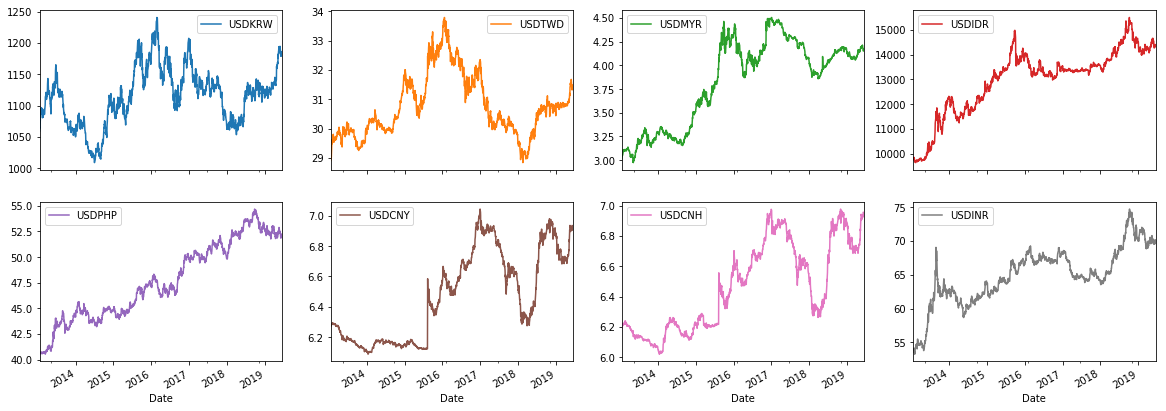

In [3]:
d.plot(subplots=True, layout=(4, 4), figsize=(20, 15));

In [4]:
d.describe()

,USDKRW,USDTWD,USDMYR,USDIDR,USDPHP,USDCNY,USDCNH,USDINR
count,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000,1655.000000
mean,1115.233662,30.761794,3.835087,12970.080967,47.670704,6.470716,6.465492,64.909039
std,45.248084,1.053612,0.450050,1330.856661,3.766645,0.293009,0.288560,4.157277
min,1008.750000,28.840000,2.974200,9637.500000,40.520000,6.088500,6.019950,53.245000
25%,1081.450000,29.965500,3.295825,12122.000000,44.552500,6.169875,6.204850,62.347500
50%,1119.085000,30.562000,4.017300,13347.500000,47.085000,6.430650,6.434000,64.980000
75%,1140.500000,31.447500,4.184350,13795.500000,51.125000,6.721250,6.722000,67.585000
max,1240.750000,33.790000,4.505000,15505.000000,54.690000,7.044000,6.977700,74.720000


#### ACF plots

In [5]:
d.diff(1).describe()

,USDKRW,USDTWD,USDMYR,USDIDR,USDPHP,USDCNY,USDCNH,USDINR
count,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000,1654.00000
mean,0.076904,0.001557,0.000703,2.756348,0.007068,0.000390,0.000452,0.00971
std,5.519537,0.096842,0.019579,71.246587,0.149470,0.015543,0.015628,0.27799
min,-25.600000,-0.436000,-0.202650,-557.500000,-0.835000,-0.123750,-0.115600,-1.52000
25%,-3.290000,-0.044375,-0.007238,-29.000000,-0.080000,-0.004500,-0.005300,-0.12500
50%,-0.070000,0.002000,0.000950,1.750000,0.005000,0.000000,0.000200,0.00000
75%,3.428750,0.050000,0.009250,35.000000,0.090000,0.005287,0.006400,0.14000
max,22.900000,0.550000,0.192400,477.500000,0.785000,0.233700,0.200900,2.36500


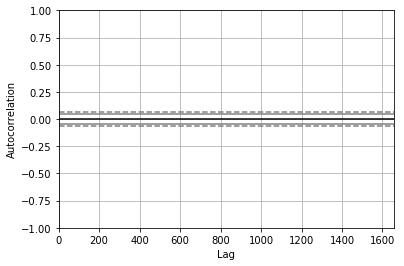

In [6]:
autocorrelation_plot(d['USDKRW'].diff());

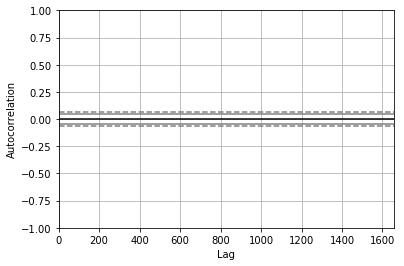

In [7]:
autocorrelation_plot(d.diff(2));

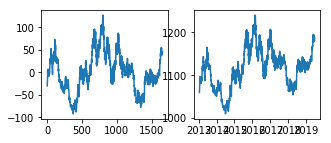

In [8]:
# detrending?
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
ax[0].plot(detrend(d['USDKRW']))
ax[1].plot(d['USDKRW'])

#### Correlation

In [9]:
d.corr()

,USDKRW,USDTWD,USDMYR,USDIDR,USDPHP,USDCNY,USDCNH,USDINR
USDKRW,1.000000,0.743457,0.668636,0.431714,0.310903,0.564456,0.563504,0.490797
USDTWD,0.743457,1.000000,0.512787,0.435250,0.061810,0.290972,0.335101,0.442119
USDMYR,0.668636,0.512787,1.000000,0.844572,0.789163,0.835321,0.857735,0.779523
USDIDR,0.431714,0.435250,0.844572,1.000000,0.845089,0.642561,0.696837,0.896335
USDPHP,0.310903,0.061810,0.789163,0.845089,1.000000,0.776376,0.788684,0.820775
USDCNY,0.564456,0.290972,0.835321,0.642561,0.776376,1.000000,0.990660,0.713875
USDCNH,0.563504,0.335101,0.857735,0.696837,0.788684,0.990660,1.000000,0.741462
USDINR,0.490797,0.442119,0.779523,0.896335,0.820775,0.713875,0.741462,1.000000


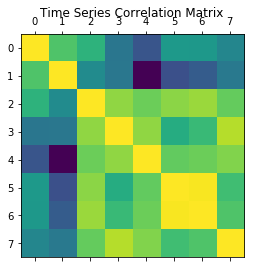

In [10]:
plt.matshow(d.corr())
plt.title('Time Series Correlation Matrix')
plt.show()

Normalizing `d` for PCA

In [11]:
d_norm = (d - d.mean())/d.std()

In [12]:
pca = PCA(2).fit(np.array(d_norm))

In [13]:
embeddings = pca.transform(d_norm)

Text(0.5, 1.0, 'PCA decomposition of spot rate data (days elapsed since 2013)')

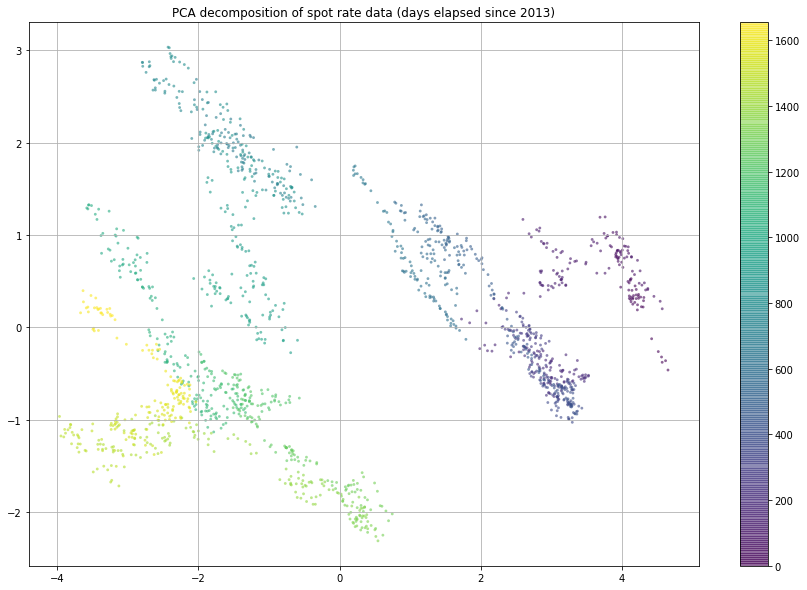

In [14]:
fig = plt.figure(figsize=(15,10))
x = np.linspace(start=0, stop=len(embeddings), num=len(embeddings))
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=8, \
            alpha=0.6, edgecolors='none', c=x)
plt.colorbar()
plt.grid(True)
plt.title('PCA decomposition of spot rate data (days elapsed since 2013)')

In [15]:
pca.explained_variance_ratio_

array([0.69899995, 0.16519754])

## Return PCA

In [16]:
logret_norm = (np.log(d).diff(1) - np.log(d).diff(1).mean())/np.log(d).diff(1).std()
logret_norm = logret_norm.dropna()
pca = PCA(2).fit(np.array(logret_norm))
embeddings = pca.transform(logret_norm)

Text(0.5, 1.0, 'PCA decomposition of log return data (days elapsed since 2013)')

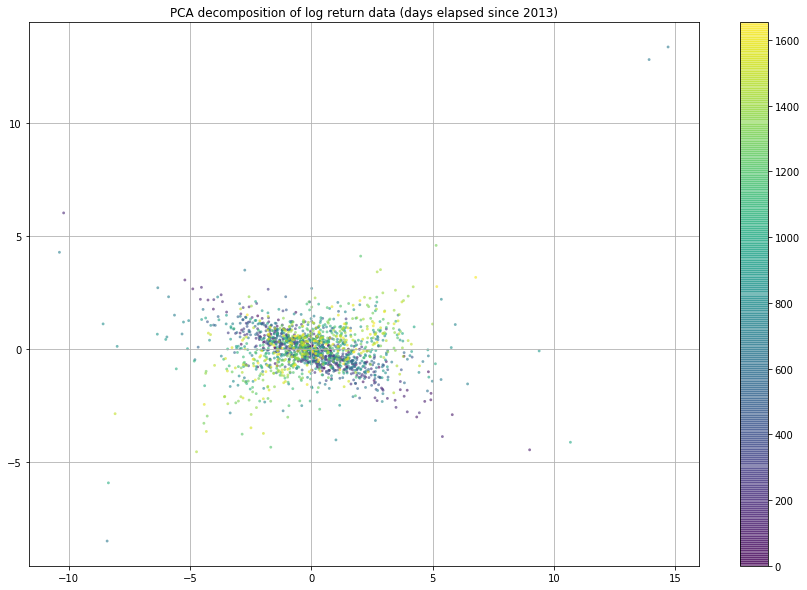

In [17]:
fig = plt.figure(figsize=(15,10))
x = np.linspace(start=0, stop=len(embeddings), num=len(embeddings))
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=8, \
            alpha=0.6, edgecolors='none', c=x)
plt.colorbar()
plt.grid(True)
plt.title('PCA decomposition of log return data (days elapsed since 2013)')

# tSNE

In [18]:
embeddings = TSNE(2).fit_transform(d_norm)

Text(0.5, 1.0, 'tSNE decomposition of spot rate (days elapsed since 2013)')

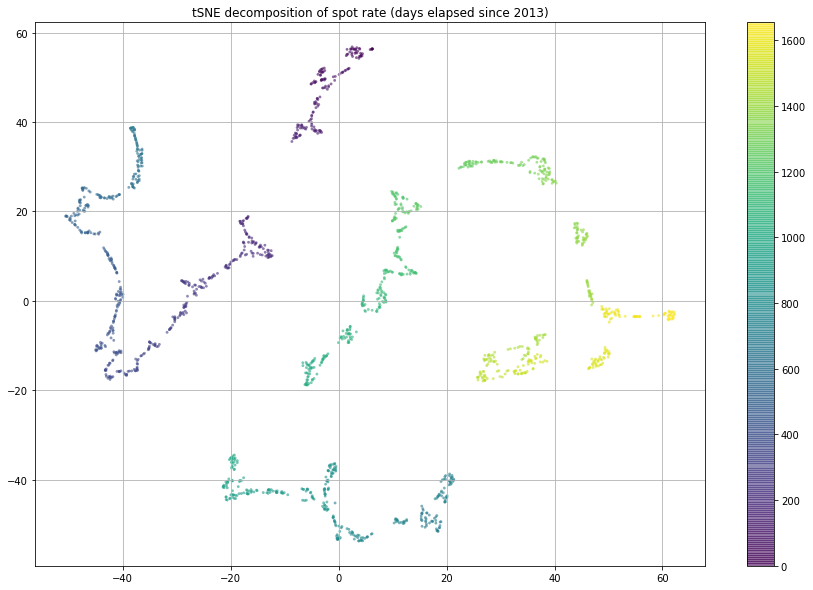

In [19]:
fig = plt.figure(figsize=(15,10))
x = np.linspace(start=0, stop=len(embeddings), num=len(embeddings))
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=8, \
            alpha=0.6, edgecolors='none', c=x)
plt.colorbar()
plt.grid(True)
plt.title('tSNE decomposition of spot rate (days elapsed since 2013)')

In [20]:
embeddings = TSNE(2).fit_transform(logret_norm)

Text(0.5, 1.0, 'tSNE decomposition of log returns (days elapsed since 2013)')

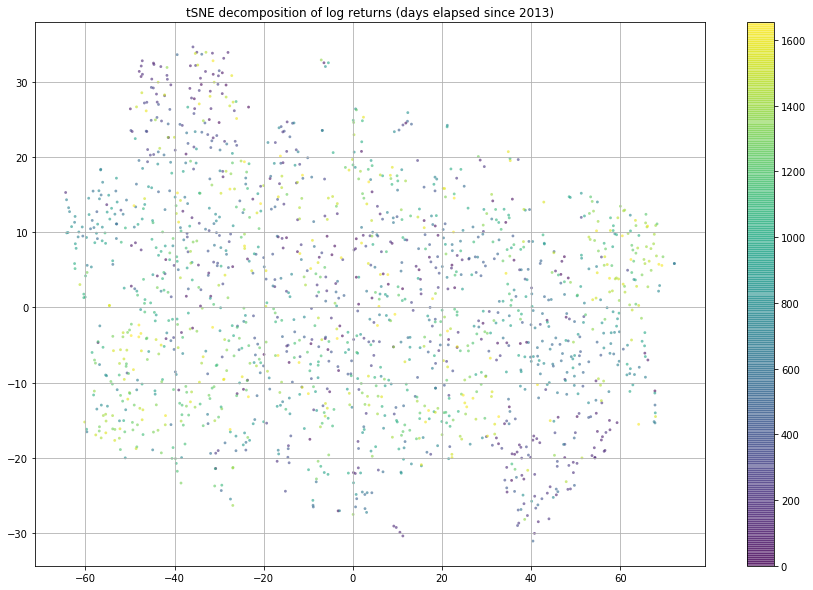

In [21]:
fig = plt.figure(figsize=(15,10))
x = np.linspace(start=0, stop=len(embeddings), num=len(embeddings))
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=8, \
            alpha=0.6, edgecolors='none', c=x)
plt.colorbar()
plt.grid(True)
plt.title('tSNE decomposition of log returns (days elapsed since 2013)')

## Return analysis

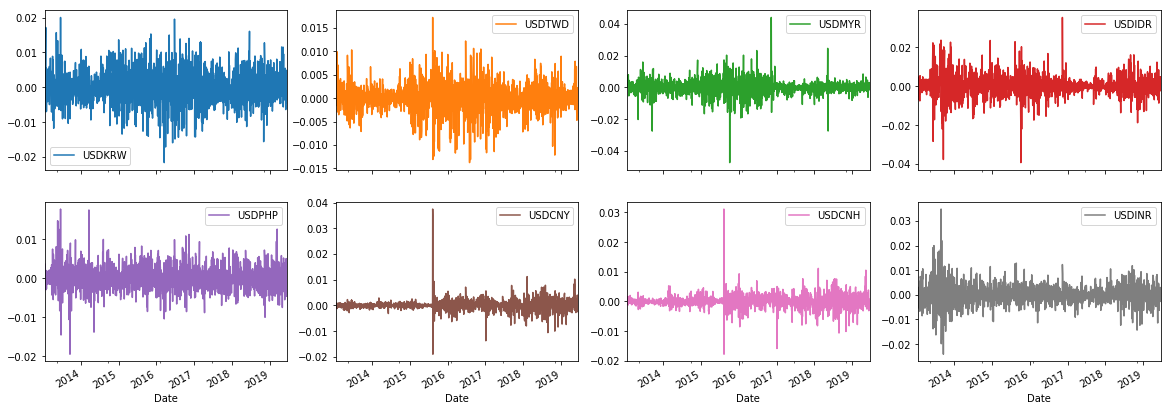

In [27]:
np.log(d).diff(1).plot(subplots=True, layout=(4, 4), figsize=(20, 15));

In [28]:
np.log(d).diff(1).describe()

,USDKRW,USDTWD,USDMYR,USDIDR,USDPHP,USDCNY,USDCNH,USDINR
count,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000
mean,0.000069,0.000052,0.000197,0.000230,0.000153,0.000059,0.000069,0.000157
std,0.004894,0.003094,0.004976,0.005572,0.003157,0.002371,0.002379,0.004295
min,-0.021644,-0.013769,-0.047400,-0.039352,-0.019425,-0.018972,-0.017788,-0.024098
25%,-0.002985,-0.001434,-0.001920,-0.002209,-0.001674,-0.000687,-0.000840,-0.001934
50%,-0.000063,0.000066,0.000237,0.000136,0.000100,0.000000,0.000030,0.000000
75%,0.003111,0.001611,0.002480,0.002711,0.001891,0.000812,0.000980,0.002190
max,0.020022,0.017209,0.044079,0.035481,0.017657,0.037451,0.031119,0.034851


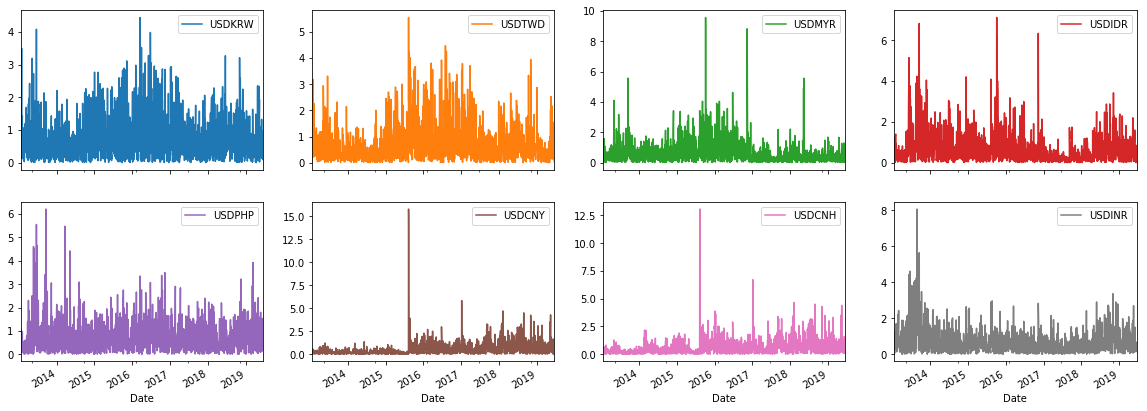

In [29]:
def return_z_scores(df, mode='log'):
    if mode=='log': return (np.log(d).diff(1) - np.log(d).diff(1).mean()) / np.log(d).diff(1).std(ddof=0)
    else: return (d.pct_change().diff(1) - d.pct_change().diff(1).mean()) / d.pct_change().diff(1).std(ddof=0) 
rz = abs(return_z_scores(d))
rz.plot(subplots=True, layout=(4, 4), figsize=(20, 15));

In [31]:
rz[rz>1].describe()

,USDKRW,USDTWD,USDMYR,USDIDR,USDPHP,USDCNY,USDCNH,USDINR
count,461.000000,402.000000,329.000000,354.000000,444.000000,282.000000,332.000000,369.000000
mean,1.596883,1.691735,1.800136,1.764056,1.608727,1.766320,1.756759,1.725543
std,0.554419,0.733729,0.950176,0.887915,0.669570,1.397748,1.080954,0.843338
min,1.000595,1.002380,1.003439,1.000846,1.000210,1.000615,1.002173,1.003558
25%,1.183049,1.184376,1.226814,1.180712,1.196117,1.168323,1.217342,1.176342
50%,1.436757,1.384850,1.537548,1.502863,1.421441,1.443957,1.445238,1.458921
75%,1.868795,2.003784,2.029090,1.964094,1.778631,1.873257,1.897098,1.943111
max,4.437823,5.547302,9.568568,7.106193,6.203097,15.776099,13.056125,8.079649


In [32]:
d.pct_change().diff(1).describe()

,USDKRW,USDTWD,USDMYR,USDIDR,USDPHP,USDCNY,USDCNH,USDINR
count,1653.000000,1.653000e+03,1653.000000,1653.000000,1653.000000,1.653000e+03,1.653000e+03,1.653000e+03
mean,-0.000003,-7.932538e-07,-0.000004,0.000001,-0.000003,1.853529e-07,1.082153e-07,7.771405e-07
std,0.006973,4.421476e-03,0.007009,0.007832,0.004441,3.209043e-03,3.283672e-03,5.987356e-03
min,-0.024351,-2.037878e-02,-0.060653,-0.043681,-0.023731,-5.453691e-02,-4.923860e-02,-4.053404e-02
25%,-0.004422,-2.309285e-03,-0.003042,-0.003744,-0.002735,-1.213108e-03,-1.331405e-03,-3.088986e-03
50%,0.000072,-1.240666e-06,-0.000011,0.000058,-0.000011,-2.231969e-05,-3.622377e-05,1.490732e-04
75%,0.004455,2.197516e-03,0.003321,0.003816,0.002642,1.061332e-03,1.323895e-03,3.125849e-03
max,0.022954,2.221591e-02,0.058415,0.053797,0.024170,3.823481e-02,2.254336e-02,3.339514e-02


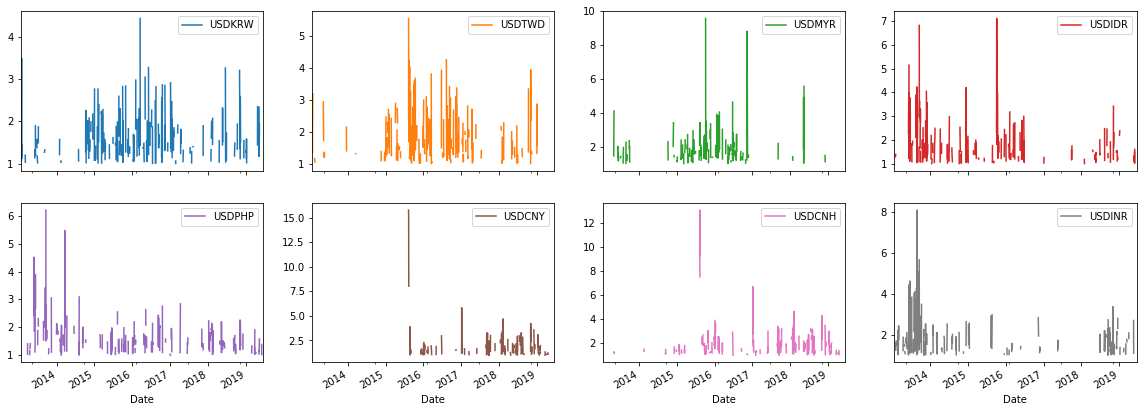

In [34]:
rz[rz>1].plot(subplots=True, layout=(4, 4), figsize=(20, 15));

In [35]:
rz_pct = abs(return_z_scores(d, mode='pct'))

Zscores for `pct_change` 

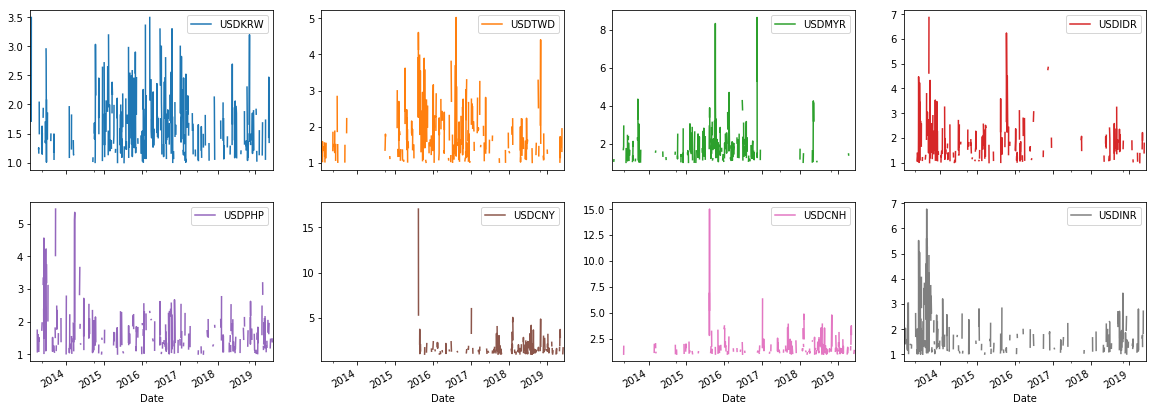

In [37]:
rz_pct[rz_pct>1].plot(subplots=True, layout=(4, 4), figsize=(20, 15));

Fitting pareto on `pct_change` with abs(zscores) > 1

In [38]:
rz_pct = rz_pct.dropna()
rz = rz.dropna()

In [39]:
params = []
for c in rz_pct.columns:
    params.append((c, pareto.fit(rz_pct[c][rz_pct[c]>1], 4, loc=0, scale=1)))

In [40]:
params

[('USDKRW', (2.493953265674179, -5.3669004743629545e-06, 1.000084367825116)),
 ('USDTWD', (2.1692310823763696, 0.0015382262368647042, 1.0011089063089655)),
 ('USDMYR', (2.098496583193133, 0.0031423477191143685, 0.9984384686473233)),
 ('USDIDR', (2.1105384486139727, 0.0031487109827316962, 0.9975188228521761)),
 ('USDPHP', (2.433763343058688, 0.0022343206503312447, 0.9985558284389993)),
 ('USDCNY', (2.211133930417553, 0.005739783703869464, 0.9951581236965026)),
 ('USDCNH', (2.2125137291579398, 0.0020523505050661214, 1.00397443187871)),
 ('USDINR', (2.2162954120129124, 0.003970374472132471, 0.9975500632911183))]

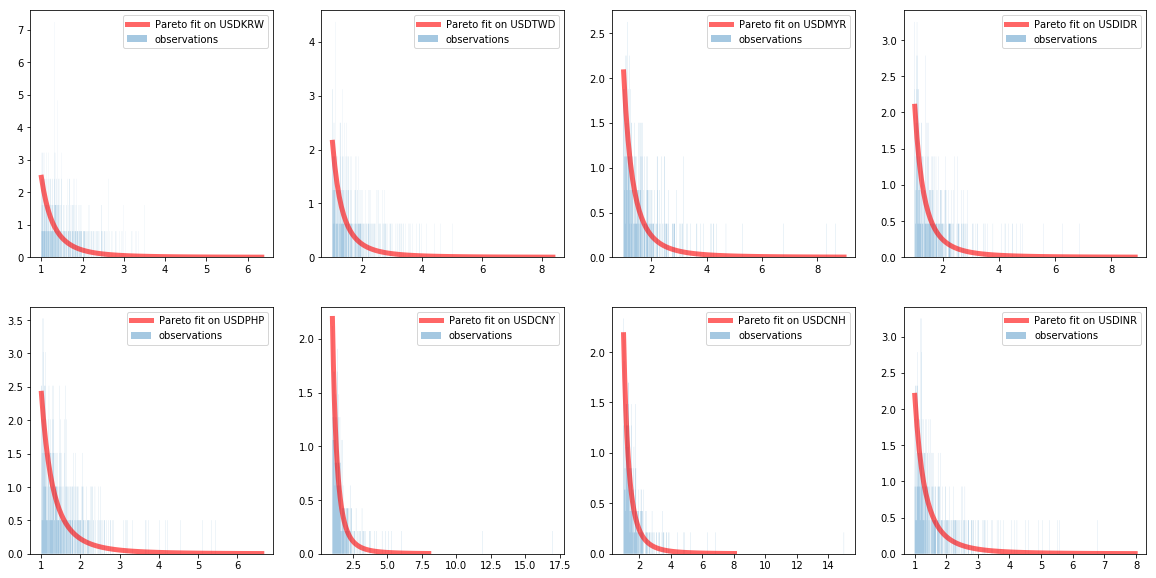

In [41]:
currs = [c for c in rz_pct.columns]
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, c in enumerate(rz_pct.columns):
    r = rz_pct[c][rz_pct[c]>1].dropna()
    b, loc, scale =params[i][1][0], params[i][1][1], params[i][1][2]
    x = np.linspace(pareto.ppf(0.01, b, loc=loc, scale=scale), \
                  pareto.ppf(0.99, b, loc=loc, scale=scale), 100)
    ax[i//4][i%4].plot(x, pareto.pdf(x, b, loc=loc, scale=scale), \
           'r-', lw=5, alpha=0.6, label='pareto pdf')
    ax[i//4][i%4].hist(r, density=True, histtype='stepfilled', alpha=0.4, lw=5, bins=1000)
    ax[i//4][i%4].legend(['Pareto fit on {}'.format(currs[i]),'observations'])

Fitting pareto on `log returns` with abs(zscores) > 1

In [42]:
params = []
for c in rz.columns:
    params.append((c, pareto.fit(rz[c][rz[c]>1], 4.5, loc=0, scale=1)))

In [43]:
params

[('USDKRW', (2.3978110335459792, -0.0013875915361322264, 1.0019825198173364)),
 ('USDTWD', (2.2191829751188576, 0.0037991896143050536, 0.9985807381087641)),
 ('USDMYR', (2.0054672622802183, 0.0009071411393096092, 1.0025317363263366)),
 ('USDIDR', (2.0803808449562275, 0.003265043575606792, 0.9975812026139039)),
 ('USDPHP', (2.403331698662809, 1.3536020201880655e-05, 1.0001965708051435)),
 ('USDCNY', (2.2069210503001884, 0.0018697518358246586, 0.9987452960991259)),
 ('USDCNH', (2.129566359701979, 0.0037629718992831414, 0.9984099201487051)),
 ('USDINR', (2.1628873433997367, 0.002158854285581895, 1.0013986768701661))]

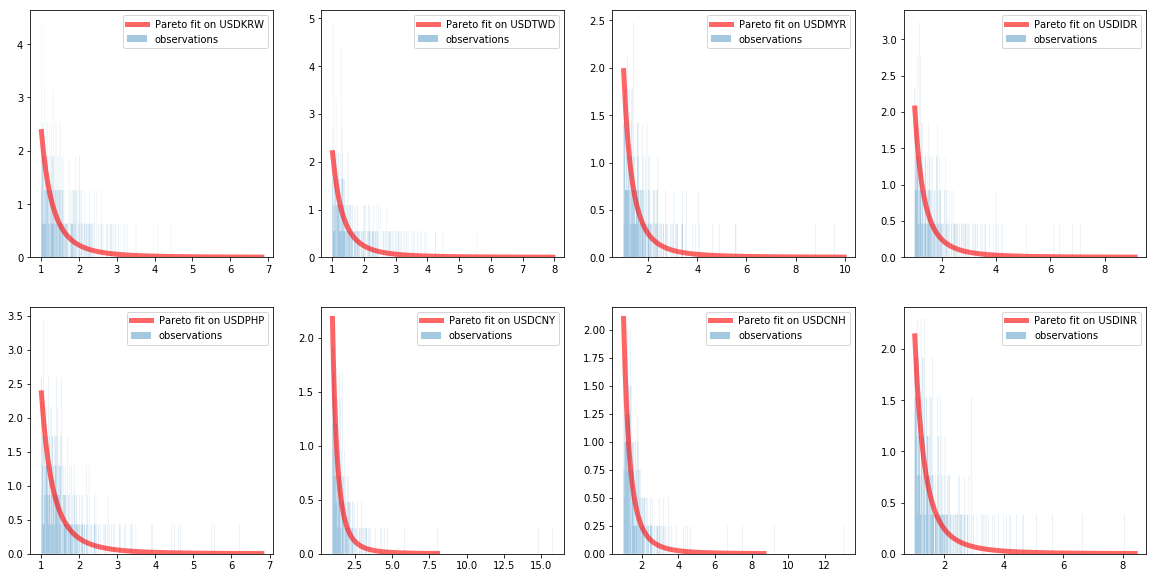

In [44]:
currs = [c for c in rz_pct.columns]
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, c in enumerate(rz_pct.columns):
    r = rz[c][rz[c]>1].dropna()
    b, loc, scale =params[i][1][0], params[i][1][1], params[i][1][2]
    x = np.linspace(pareto.ppf(0.01, b, loc=loc, scale=scale), \
                  pareto.ppf(0.99, b, loc=loc, scale=scale), 100)
    ax[i//4][i%4].plot(x, pareto.pdf(x, b, loc=loc, scale=scale), \
           'r-', lw=5, alpha=0.6, label='pareto pdf')
    ax[i//4][i%4].hist(r, density=True, histtype='stepfilled', alpha=0.4, lw=5, bins=1000)
    ax[i//4][i%4].legend(['Pareto fit on {}'.format(currs[i]),'observations'])

## Asymmetric Pareto Fit

Now we fit pareto distributions separately for large positive and negative returns (zscores)

In [45]:
rz_pos = return_z_scores(d, mode='pct')
rz_pos = rz_pos[rz_pos>1]
rz_neg = return_z_scores(d)
rz_neg = abs(rz_neg[rz_neg<-1])

In [46]:
params_pos = []
for c in rz_pct.columns:
    params_pos.append((c, pareto.fit(rz_pos[c].dropna(), 3, loc=0, scale=1)))

In [47]:
params_pos

[('USDKRW', (10182139.06000112, -5626302.55638607, 5626303.557237208)),
 ('USDTWD', (2.142516666676075, 0.0010969113307836217, 1.001550222134921)),
 ('USDMYR', (2.2785853345146974, 0.0011743176165945278, 1.0023287530261844)),
 ('USDIDR', (6.052228326877437, -2.5757093659922723, 3.5763769001075927)),
 ('USDPHP', (2.441883568166477, 0.0007468396047925568, 1.0027395066239313)),
 ('USDCNY', (2.119856678523653, 0.0007816315485330333, 1.0069485952972266)),
 ('USDCNH', (5.528166652665597, -2.345425744399524, 3.3523988249022665)),
 ('USDINR', (2.196306086748402, 0.0009489510083067647, 1.0011259827335146))]

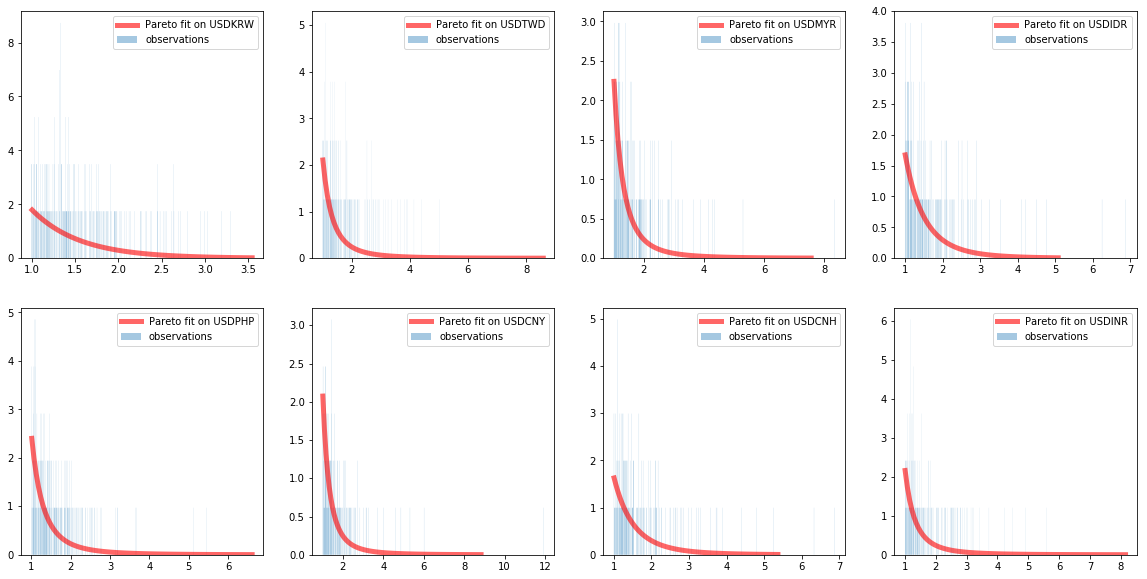

In [48]:
currs = [c for c in rz_pct.columns]
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, c in enumerate(rz_pct.columns):
    r = rz_pos[c].dropna()
    b, loc, scale =params_pos[i][1][0], params_pos[i][1][1], params_pos[i][1][2]
    x = np.linspace(pareto.ppf(0.01, b, loc=loc, scale=scale), \
                  pareto.ppf(0.99, b, loc=loc, scale=scale), 100)
    ax[i//4][i%4].plot(x, pareto.pdf(x, b, loc=loc, scale=scale), \
           'r-', lw=5, alpha=0.6, label='pareto pdf')
    ax[i//4][i%4].hist(r, density=True, histtype='stepfilled', alpha=0.4, lw=5, bins=1000)
    ax[i//4][i%4].legend(['Pareto fit on {}'.format(currs[i]),'observations'])

In [49]:
params_neg = []
for c in rz_pct.columns:
    params_neg.append((c, pareto.fit(rz_neg[c].dropna(), 2, loc=0, scale=1)))

In [50]:
params_neg

[('USDKRW', (2.390047637724776, -0.0006250777580488565, 1.0050588707227983)),
 ('USDTWD', (2.033230057286108, 0.00023851622562416787, 1.0021414115544038)),
 ('USDMYR', (1.9508598769554637, 0.00023228299349623718, 1.0089968447184936)),
 ('USDIDR', (2.2647201989949908, 5.277095125018959e-05, 1.000793473827939)),
 ('USDPHP', (12.704116699680327, -5.571729284277575, 6.572864886125949)),
 ('USDCNY', (2.2306176441582117, -4.2057246888859394e-05, 1.006161916405739)),
 ('USDCNH', (8.43479233526994, -4.800021075078975, 5.802193969120168)),
 ('USDINR', (2.1387334022168396, -0.00013747571078390073, 1.0044136499795884))]

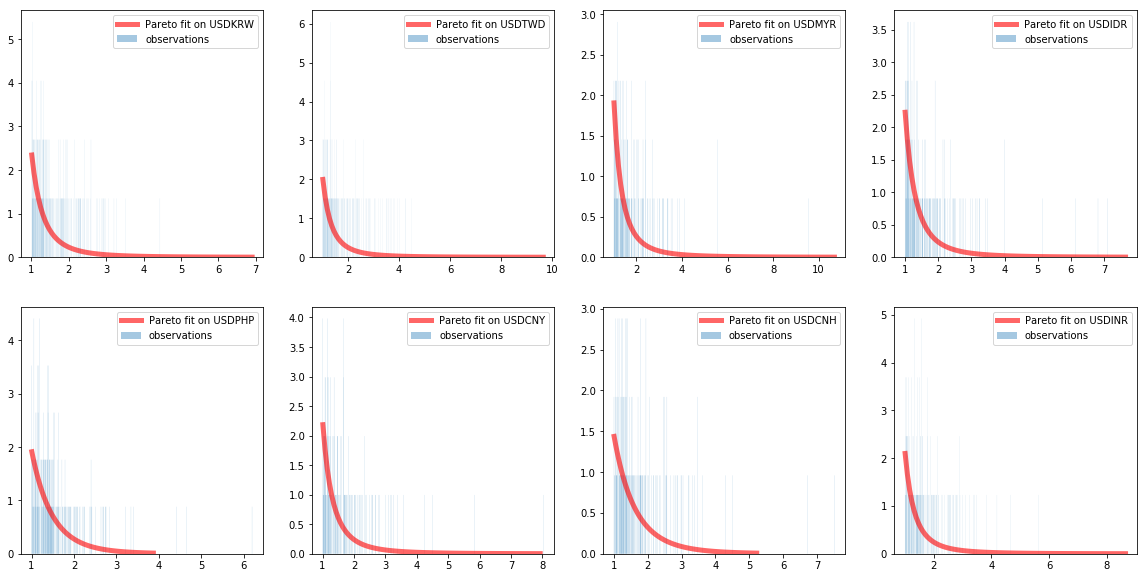

In [51]:
currs = [c for c in rz_pct.columns]
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, c in enumerate(rz_pct.columns):
    r = rz_neg[c].dropna()
    b, loc, scale =params_neg[i][1][0], params_neg[i][1][1], params_neg[i][1][2]
    x = np.linspace(pareto.ppf(0.01, b, loc=loc, scale=scale), \
                  pareto.ppf(0.99, b, loc=loc, scale=scale), 100)
    ax[i//4][i%4].plot(x, pareto.pdf(x, b, loc=loc, scale=scale), \
           'r-', lw=5, alpha=0.6, label='pareto pdf')
    ax[i//4][i%4].hist(r, density=True, histtype='stepfilled', alpha=0.4, lw=5, bins=1000)
    ax[i//4][i%4].legend(['Pareto fit on {}'.format(currs[i]),'observations'])

Aligned:

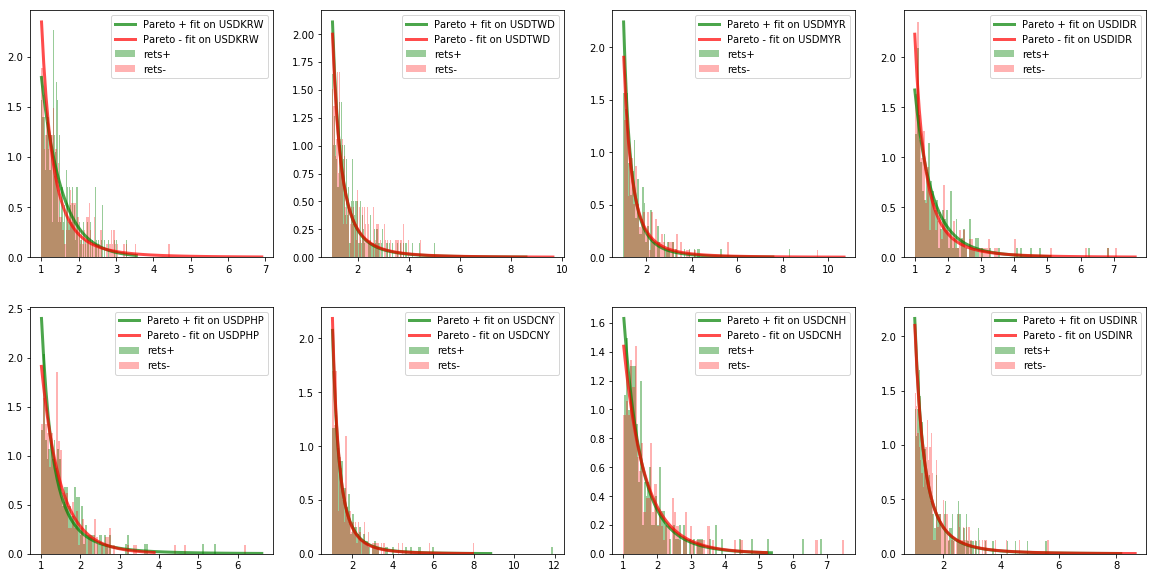

In [52]:
currs = [c for c in rz_pct.columns]
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, c in enumerate(rz_pct.columns):
    r = rz_pos[c].dropna()
    b, loc, scale =params_pos[i][1][0], params_pos[i][1][1], params_pos[i][1][2]
    x = np.linspace(pareto.ppf(0.01, b, loc=loc, scale=scale), \
              pareto.ppf(0.99, b, loc=loc, scale=scale), 100)
    ax[i//4][i%4].plot(x, pareto.pdf(x, b, loc=loc, scale=scale), \
       'r-', lw=3, alpha=0.7, label='pareto pdf', color='green')
    
    ax[i//4][i%4].hist(r, density=True, histtype='stepfilled', alpha=0.4, lw=2, bins=100, \
                      color='green')
    
    r = rz_neg[c].dropna()
    b, loc, scale =params_neg[i][1][0], params_neg[i][1][1], params_neg[i][1][2]
    x = np.linspace(pareto.ppf(0.01, b, loc=loc, scale=scale), \
              pareto.ppf(0.99, b, loc=loc, scale=scale), 100)
    ax[i//4][i%4].plot(x, pareto.pdf(x, b, loc=loc, scale=scale), \
           'r-', lw=3, alpha=0.7, label='pareto pdf', color='red')
    
    ax[i//4][i%4].hist(r, density=True, histtype='stepfilled', alpha=0.3, lw=2, bins=100, \
                      color='red')
    
    ax[i//4][i%4].legend(['Pareto + fit on {}'.format(currs[i]), 'Pareto - fit on {}'.format(currs[i]), \
                          'rets+', 'rets-'])

## Regime shifts: evaluating trading difficulty

In [8]:
d.head(10)

,USDKRW,USDTWD,USDMYR,USDIDR,USDPHP,USDCNY,USDCNH,USDINR
Date,,,,,,,,
2013-01-18,1059.000,28.9100,3.01525,9842.0,40.520,6.27425,6.19050,54.090
2013-01-21,1064.960,28.9525,3.03715,9819.5,40.665,6.27750,6.19350,54.090
2013-01-22,1064.375,28.9550,3.04415,9755.0,40.565,6.27600,6.19700,53.805
2013-01-23,1067.800,28.9675,3.04815,9761.5,40.580,6.27650,6.20450,53.970
2013-01-24,1070.350,29.0250,3.04815,9784.0,40.630,6.27900,6.20735,53.965
2013-01-25,1076.100,29.1475,3.05365,9800.0,40.665,6.28350,6.21300,54.030
2013-01-28,1094.715,29.4380,3.06525,9848.5,40.735,6.28950,6.22350,54.105
2013-01-29,1086.995,29.5250,3.08445,9819.5,40.725,6.29200,6.22200,53.910
2013-01-30,1085.350,29.4775,3.08605,9811.0,40.605,6.28425,6.21450,53.625


## Appendix: Determining optimal window for rolling training and validation

In [4]:
c = d.columns

In [16]:
pca_info = []
for window in range(10, 360, 10):
    pre_emb = (d - d.rolling(window).mean())/d.rolling(window).std()
    pca = PCA(8)
    emb = pca.fit_transform(pre_emb.dropna())
    c = pca.explained_variance_ratio_
    rel_components = sum(pca.explained_variance_ratio_)**2/sum(pca.explained_variance_ratio_**2)
    pca_info.append((window, rel_components))

Text(0.5, 1.0, 'PCA factors for NDF pair spots')

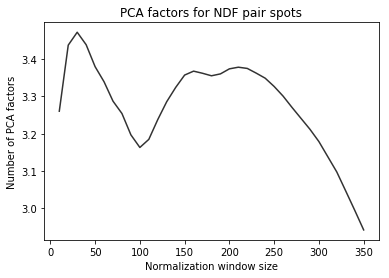

In [25]:
plt.plot([el[0] for el in pca_info], [el[1] for el in pca_info], color='black', alpha=0.8)
plt.xlabel('Normalization window size')
plt.ylabel('Number of PCA factors')
plt.title('PCA factors for NDF pair spots')